<strong><h1>Random Forest Algorithm</h1></strong>

In [35]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

#Exporting model
import pickle

In [36]:
data = pd.read_csv('../../models/gianluca/DATA_PCA.csv', sep=',')
data['Target'] = data['Target'].map({'Dropout':0,'Enrolled':1,'Graduate':2})
data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Target
0,-0.314242,-0.205719,-0.028824,0.206659,0.012864,-0.874508,0.387179,0.010646,0
1,-0.470709,-0.329179,0.884960,-0.093840,-0.083021,0.226558,0.106516,-0.184132,2
2,-0.396169,0.580298,0.717272,0.092688,0.067955,-0.065536,-0.096558,-0.204557,0
3,-0.130125,0.273844,-0.174658,-0.023552,-0.576278,0.067090,-0.072535,-0.123530,2
4,-0.131716,0.229628,-0.067836,-0.505245,-0.335535,-0.094679,0.105542,0.325822,2


In [37]:
X_dataWithoutTarget = data.drop('Target', axis=1)
Y_target = data['Target']


#Split dataset into 70% training and 30% (testing + validation)
X_train, X_testval, y_train, y_testval = train_test_split(X_dataWithoutTarget, Y_target, test_size=0.3, random_state=42)

#Split the remaining 30% into 20% testing and 10% validation
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, test_size=1/3, random_state=42)

#Check the resulting sizes
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"Validation set: {len(X_val)} samples")

Training set: 3096 samples
Testing set: 885 samples
Validation set: 443 samples


Training a Random Forest Model without hyper parameter testing (For Comparison)

In [38]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [39]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7197740112994351


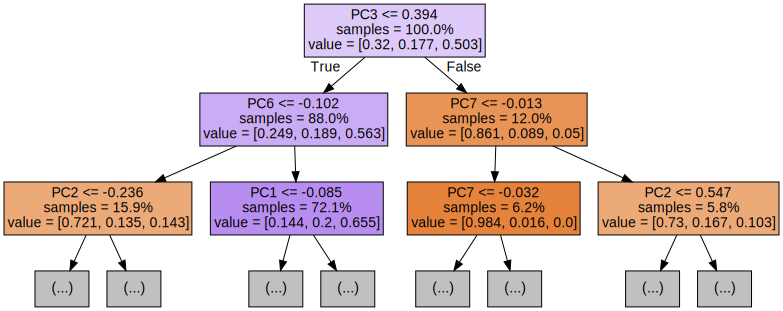

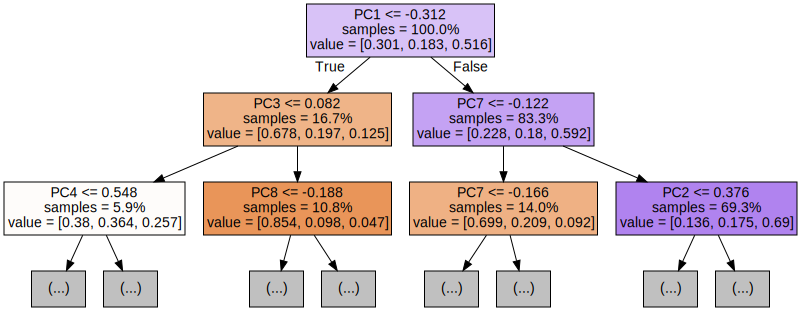

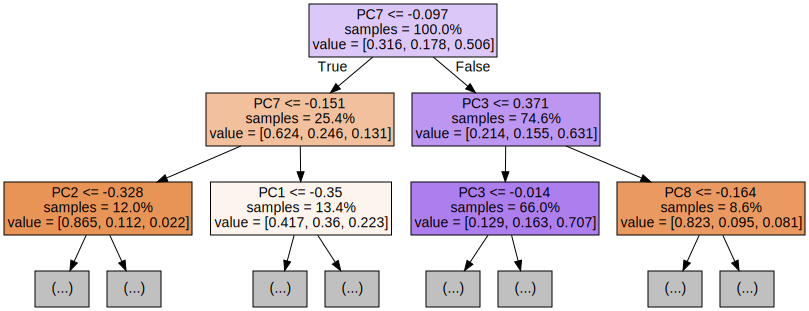

In [40]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
param_dist = {
    'n_estimators': randint(50, 500),           # Number of trees
    'max_depth': randint(1, 20),                # Maximum depth of the tree
    'min_samples_split': randint(2, 20),        # Minimum number of samples to split a node
    'min_samples_leaf': randint(1, 20),         # Minimum samples required at a leaf node
    'max_features': uniform(0.1, 0.9),          # Fraction of features considered for splitting
    'bootstrap': [True, False],                 # Whether bootstrap samples are used
}

# Create a random forest classifier
hyper_rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(
    hyper_rf,
    param_distributions=param_dist,
    n_iter=50,  # More iterations for better exploration
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',  # Choose appropriate metric
    random_state=42,      # For reproducibility
    n_jobs=-1            # Use all processors for faster computation
)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C17513F290>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C17548D0D0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C174F21970>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C174F21C40>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C17514A780>},
                   random_state=42, scoring='accuracy')

In [42]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'bootstrap': True, 'max_depth': 7, 'max_features': np.float64(0.4810613326357327), 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 185}


In [43]:
y_pred = best_rf.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", best_rf_accuracy)

Accuracy: 0.7197740112994351


<strong><h3>Exporting the model</h3></strong>

In [ ]:
# Save the model to a file
with open('random_forest_model.pkl', 'wb') as f:
    if (best_rf_accuracy > accuracy):
        print("Exporting hyper parameter trained model")
        pickle.dump(best_rf, f)
    else:
        print("Exporting non-hyper parameter trained model")
        pickle.dump(rf, f)
print("Model exported successfully!")